In [1]:
from google.colab import files

# Subir archivo JSON
uploaded = files.upload()

Saving crypto_db.crypto_data2.json to crypto_db.crypto_data2.json


In [2]:
from pyspark.sql import SparkSession

# Inicializar sesión de Spark
spark = SparkSession.builder \
    .appName("Crypto Analysis") \
    .getOrCreate()

# Leer el archivo JSON
df = spark.read.option("multiline", "true").json("crypto_db.crypto_data2.json")

# Mostrar primeras filas
df.show(5, truncate=False)

# Esquema del DataFrame
df.printSchema()

+--------------------------+-----------+-------+--------------------------+
|_id                       |currency   |price  |timestamp                 |
+--------------------------+-----------+-------+--------------------------+
|{673c78c33f89a1dd8287c3fb}|Binancecoin|617.17 |2024-11-19T11:38:43.122457|
|{673c78c33f89a1dd8287c3fc}|Bitcoin    |91659.0|2024-11-19T11:38:43.144313|
|{673c78c33f89a1dd8287c3fd}|Ethereum   |3119.0 |2024-11-19T11:38:43.146319|
|{673c78cd3f89a1dd8287c3fe}|Binancecoin|617.17 |2024-11-19T11:38:53.519422|
|{673c78cd3f89a1dd8287c3ff}|Bitcoin    |91659.0|2024-11-19T11:38:53.520960|
+--------------------------+-----------+-------+--------------------------+
only showing top 5 rows

root
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- price: double (nullable = true)
 |-- timestamp: string (nullable = true)



In [3]:
from pyspark.sql.functions import col

# Seleccionar columnas y aplanar el campo _id
df = df.select(
    col("currency"),
    col("price"),
    col("timestamp"),
    col("_id.$oid").alias("id")
)

# Mostrar primeras filas
df.show(5, truncate=False)

+-----------+-------+--------------------------+------------------------+
|currency   |price  |timestamp                 |id                      |
+-----------+-------+--------------------------+------------------------+
|Binancecoin|617.17 |2024-11-19T11:38:43.122457|673c78c33f89a1dd8287c3fb|
|Bitcoin    |91659.0|2024-11-19T11:38:43.144313|673c78c33f89a1dd8287c3fc|
|Ethereum   |3119.0 |2024-11-19T11:38:43.146319|673c78c33f89a1dd8287c3fd|
|Binancecoin|617.17 |2024-11-19T11:38:53.519422|673c78cd3f89a1dd8287c3fe|
|Bitcoin    |91659.0|2024-11-19T11:38:53.520960|673c78cd3f89a1dd8287c3ff|
+-----------+-------+--------------------------+------------------------+
only showing top 5 rows



In [4]:
# Importación de la función to_timestamp desde PySpark
from pyspark.sql.functions import to_timestamp

# Convertir la columna 'timestamp' de tipo string a un formato de fecha y hora
df = df.withColumn("timestamp", to_timestamp("timestamp"))

# Mostrar las primeras filas procesadas
df.show(5, truncate=False)

+-----------+-------+--------------------------+------------------------+
|currency   |price  |timestamp                 |id                      |
+-----------+-------+--------------------------+------------------------+
|Binancecoin|617.17 |2024-11-19 11:38:43.122457|673c78c33f89a1dd8287c3fb|
|Bitcoin    |91659.0|2024-11-19 11:38:43.144313|673c78c33f89a1dd8287c3fc|
|Ethereum   |3119.0 |2024-11-19 11:38:43.146319|673c78c33f89a1dd8287c3fd|
|Binancecoin|617.17 |2024-11-19 11:38:53.519422|673c78cd3f89a1dd8287c3fe|
|Bitcoin    |91659.0|2024-11-19 11:38:53.52096 |673c78cd3f89a1dd8287c3ff|
+-----------+-------+--------------------------+------------------------+
only showing top 5 rows



In [5]:
import pandas as pd

# Filtrar datos de Ethereum
ethereum_df = df.filter(df.currency == "Ethereum").select("timestamp", "price")

# Convertir a DataFrame
ethereum_data = ethereum_df.toPandas()

# Renombrar las columnas
ethereum_data = ethereum_data.rename(columns={"timestamp": "ds", "price": "y"})
ethereum_data["ds"] = pd.to_datetime(ethereum_data["ds"])

# Mostrar las primeras filas del DataFrame para verificar los datos
print(ethereum_data.head())

                          ds       y
0 2024-11-19 11:38:43.146319  3119.0
1 2024-11-19 11:38:53.521974  3119.0
2 2024-11-19 11:39:03.926473  3119.0
3 2024-11-19 11:39:14.316416  3119.0
4 2024-11-19 11:39:24.780533  3119.0


In [6]:
# Importación de la prueba Dickey-Fuller para evaluar la estacionariedad
from statsmodels.tsa.stattools import adfuller

# Verificar estacionariedad de la serie de Ethereum
adf_test_eth = adfuller(ethereum_data['y'])     # 'y' contiene los datos de precios de Ethereum
print(f"ADF Statistic: {adf_test_eth[0]}")      # Estadístico ADF
print(f"p-value: {adf_test_eth[1]}")            # Valor p asociado

# Decidir si la serie es estacionaria según el valor p
if adf_test_eth[1] > 0.05:
    print("La serie no es estacionaria. Aplicando diferenciación...")
    ethereum_data_diff = ethereum_data['y'].diff().dropna()     # Diferenciación para eliminar tendencias
else:
    print("La serie es estacionaria.")
    ethereum_data_diff = ethereum_data['y']                     # No se realiza diferenciación

ADF Statistic: -0.41468353890192355
p-value: 0.9076181343649015
La serie no es estacionaria. Aplicando diferenciación...


In [7]:
# Se realiza una segunda prueba para confirmar que la serie diferenciada es estacionaria
adf_test_eth_diff = adfuller(ethereum_data_diff)
print(f"ADF Statistic (diferenciada): {adf_test_eth_diff[0]}")
print(f"p-value (diferenciada): {adf_test_eth_diff[1]}")

if adf_test_eth_diff[1] <= 0.05:
    print("La serie ahora es estacionaria.")
else:
    print("La serie todavía no es estacionaria")


ADF Statistic (diferenciada): -16.0489985137138
p-value (diferenciada): 5.802360067506807e-29
La serie ahora es estacionaria.


In [8]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Cada tupla (p, d, q) representa los parámetros del modelo ARIMA:
# p: número de términos autoregresivos (AR)
# d: número de diferenciaciones necesarias para estacionariedad (diferencias)
# q: número de términos de media móvil (MA)

# Lista de parámetros a probar
param_list = [(2, 1, 2), (5, 2, 1), (0, 2, 2), (3, 1, 3), (4, 2, 0)]

# Diccionario para almacenar resultados
results_eth = {}

# Probar diferentes configuraciones
for params in param_list:
    print(f"Test ARIMA{params}...")
    try:
        # Ajustar el modelo ARIMA
        model = ARIMA(ethereum_data_diff, order=params)
        model_fit = model.fit()

        # Calcular métricas
        mae = mean_absolute_error(ethereum_data_diff, model_fit.fittedvalues)
        rmse = np.sqrt(mean_squared_error(ethereum_data_diff, model_fit.fittedvalues))

        # Guardar resultados
        results_eth[params] = {
            'MAE': mae,
            'RMSE': rmse,
            'AIC': model_fit.aic,
            'BIC': model_fit.bic
        }
        # Imprimir resultados del modelo actual
        print(f"ARIMA{params}: MAE={mae:.2f}, RMSE={rmse:.2f}, AIC={model_fit.aic:.2f}, BIC={model_fit.bic:.2f}")

    # Mostrar errores si el modelo no puede ser ajustado con los parámetros actuales
    except Exception as e:
        print(f"Error con ARIMA{params}: {e}")

# Selección del mejor modelo basado en AIC
best_params_eth = min(results_eth, key=lambda x: results_eth[x]['AIC'])
print(f"\nMejor modelo: ARIMA{best_params_eth}")
print(f"Resultados: {results_eth[best_params_eth]}")

Test ARIMA(2, 1, 2)...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA(2, 1, 2): MAE=0.33, RMSE=1.72, AIC=42433.84, BIC=42470.29
Test ARIMA(5, 2, 1)...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as s

ARIMA(5, 2, 1): MAE=0.60, RMSE=1.85, AIC=44113.17, BIC=44164.20
Test ARIMA(0, 2, 2)...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

ARIMA(0, 2, 2): MAE=0.40, RMSE=1.72, AIC=42480.40, BIC=42502.27
Test ARIMA(3, 1, 3)...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

ARIMA(3, 1, 3): MAE=0.35, RMSE=1.71, AIC=42426.90, BIC=42477.93
Test ARIMA(4, 2, 0)...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA(4, 2, 0): MAE=0.88, RMSE=2.34, AIC=49188.18, BIC=49224.63

Mejor modelo: ARIMA(3, 1, 3)
Resultados: {'MAE': 0.3487390942836469, 'RMSE': 1.7141750171864951, 'AIC': 42426.89805380438, 'BIC': 42477.92858118435}


In [9]:
# Remuestreo de los datos a intervalos de 1 minuto
ethereum_data_resampled = (
    ethereum_data.set_index("ds")     # Establecer el índice
    .resample("T")                    # 'T' para remuestrear a minutos
    .mean()                           # Calcular el promedio por intervalo
    .dropna()                         # Eliminar valores nulos
    .reset_index()                    # Reiniciar el índice para su posterior uso
)

# Configurar nuevamente la columna "ds" como índice
ethereum_data_resampled = ethereum_data_resampled.set_index('ds')

<ipython-input-9-30546538f600>:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("T")                    # 'T' para remuestrear a minutos


Ajustando el modelo ARIMA(3, 1, 3)...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                10831
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -21206.449
Date:                Wed, 18 Dec 2024   AIC                          42426.898
Time:                        18:53:39   BIC                          42477.929
Sample:                             0   HQIC                         42444.103
                              - 10831                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4581      0.065    -22.586      0.000      -1.585      -1.332
ar.L2         -0.9832      0.093    -10.529      0.000      -1.166      -0.800
ar.L3         -0.0088      0.063     -0.141      0.8

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-10-6c615dbe8f5b>:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  forecast_index_eth = pd.date_range(start=ethereum_data_resampled.index[-1], periods=forecast_steps_eth + 1, freq='T')[1:]


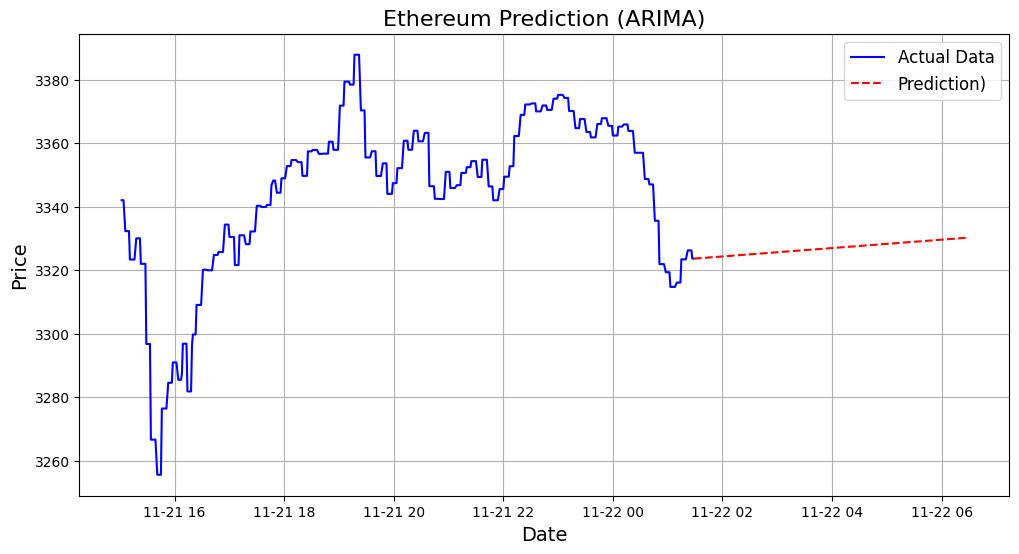

In [10]:
import matplotlib.pyplot as plt

# Ajustar el modelo ARIMA(3, 1, 3) para Ethereum
model_eth = ARIMA(ethereum_data_diff, order=(3, 1, 3))
model_fit_eth = model_eth.fit()

# Mostrar el resumen del modelo
# información estadística detallada sobre los parámetros ajustados,
# como coeficientes, errores estándar, valores AIC/BIC, y residuales
print(model_fit_eth.summary())

# Generar predicciones
forecast_steps_eth = 300  # Número de pasos a predecir
forecast_eth = model_fit_eth.forecast(steps=forecast_steps_eth)

# Crear índice para las predicciones
forecast_index_eth = pd.date_range(start=ethereum_data_resampled.index[-1], periods=forecast_steps_eth + 1, freq='T')[1:]

# Ajustar las predicciones para volver a los valores originales
forecast_cumsum_eth = forecast_eth.cumsum() + ethereum_data_resampled['y'].iloc[-1]

# Convertir predicciones a DataFrame
forecast_df_eth = pd.DataFrame({'ds': forecast_index_eth, 'y_pred': forecast_cumsum_eth})

# Visualización de los resultados
plt.figure(figsize=(12, 6))
plt.plot(ethereum_data_resampled.index[-500:], ethereum_data_resampled['y'][-500:], label='Actual Data', color='blue')
plt.plot(forecast_df_eth['ds'], forecast_df_eth['y_pred'], label='Prediction)', color='red', linestyle='--')
plt.title('Ethereum Prediction (ARIMA)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()